<img src='../images/hanzi_hero_icon.png' style="float: left; margin: 20px; height: 55px">

# Hanzi Hero: Empowering Kids to Master Chinese Characters
<div style="text-align: right"> <H3> By Jayme Zhang </div>

---

## 4. Pre-Trained CNN Model - Multiclass

In the previous notebook [03_Self_Trained_Model_Multiclass](03_Self_Trained_Model_Multiclass.ipynb), we have seen reasonable success in building a self-trained multiclass image recognition model to classify 10 handwritten Chinese character.
  
For this notebook, we will make use of transfer learning and leverage on models trained by others on large datasets to build a multiclass classifier for same 10 Chinese characters.

In [2]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications import ResNet50V2

import keras as keras
from keras import layers, initializers
from keras.preprocessing.image import ImageDataGenerator

from time import time
import datetime, os

### 4.1 Basic Setup

#### 4.1.1 Set random seed

In [3]:
# To ensure reproducibility of results
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

#### 4.1.2 Set font for output of Chinese characters

Since our labels include Chinese characters, for the characters to be displayed correctly on visualisations, we will set the fonts to be compatible.

In [4]:
# To check if the Chinese font for Simplified Chinese Songti is available
print([f for f in fm.fontManager.ttflist if 'Songti' in f.name])

[FontEntry(fname='/System/Library/Fonts/Supplemental/Songti.ttc', name='Songti SC', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')]


In [5]:
# To display Chinese characters in matplotlib
plt.rcParams['font.family'] = ['Songti SC']

### 4.2 Image Preprocessing

Here is a visual illustration on the difference between building self-trained models from scratch and using transfer learning.

![Difference between self-trained and pre-trained models](../images/transfer_learning.png)
[Image source](https://1197.medium.com/transfer-learning-with-vgg16-architecture-6685431218dd)

To make use of the pre-trained models, we will specify the following as we use `flow_from_directory` to read the image files from the directory:
  
1. We will use `preprocess_input` as the default image preprocessing fuction.
  
2. We will reshape the image size to (224, 224).  
  
3. Since we are building a multiclass model, the class_mode will be `categorical`.

In [6]:
# To read in and preprocess images from train folder
train_data = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '../data/multiclass_data/train',
    target_size=(224, 224),
    class_mode='categorical',
)

# To read in and preprocess images from train folder
val_data = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    '../data/multiclass_data/valid',
    target_size=(224, 224),
    class_mode='categorical',
)

Found 5995 images belonging to 10 classes.
Found 1424 images belonging to 10 classes.


After reading in the images from the directory, we need to find out the labels allocated for different class.

In [7]:
# To find out labels for the 10 classes
train_data.class_indices

{'你': 0,
 '吃': 1,
 '妈': 2,
 '家': 3,
 '我': 4,
 '爱': 5,
 '爸': 6,
 '的': 7,
 '衣': 8,
 '车': 9}

The results are returned in the form of a dictionary, where the Chinese character is the key, the index of the class is the value.

### 4.3 MobileNetV2 - Build Model

The first pre-trained model we will be using is MobileNetV2. Developed by Google researchers, it's a popular choice for deploying image recognition models on resource-constrained devices due to its efficient architecture and good performance.
  
We will create the model with the following arguments:
  
1. As MobileNetV2 model was trained on Imagenet dataset with 1000 classes, we will disregard its classification head and use our own dense output layer for our multiclass task. We will set `include_top=False`.
  
2. As the final layer of MobileNetV2 is a Global Pooling Layer, not a flattened layer, we will need to set `pooling='avg'` to convert the 2D array into 1D array.
  
3. We will set `pre_trained_model.trainable = False` to freeze the model as we do not want to update the weights of this pre-trained model.

In [8]:
# Import MobileNetV2
pre_trained_model = MobileNetV2(include_top=False, pooling='avg')

# Freeze the model to prevent any updates to the weights
pre_trained_model.trainable = False

Next, we will create the model architecture, and add our own dense output layer at the last layer.

In [9]:
# Create our model architecture
trf_model = Sequential() # instantiate empty sequential model using Sequential class

# Add the pre-trained model to get all the weights
trf_model.add(pre_trained_model) # pre_trained_model = input CNN layers

# Add the final output layer
trf_model.add(Dense(10, activation='softmax')) # dense 10-node layer, activation = 'softmax' for multiclass classification

trf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


### 4.4 MobileNetV2 - Compile and Fit Model

To compile the model, we will specify the following:
  
1. We will choose Adam as the `optimizer` to use as it gives good results for most cases, and a learning rate of 0.001 as a start.
  
2. The `loss` function will be categorical crossentropy, since we are doing a multiclass classification.
  
3. The most suitable `metric` for our purpose would be accuracy, as we are concerned if the model can identify the Chinese characters correctly or not. We will also monitor the Area Under the Curve (AUC), which measures the ability of the classifier to distinguish between classes.

In [10]:
# Compile model
opt = Adam(learning_rate=0.001) # optimizer with learning rate of 0.001

# Loss function
trf_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

Before we fit the model with the training data, we will set the following:
  
1. We will set the number of `epochs` to 10 as the pre-trained model should be able to adapt to our problem pretty fast.
  
2. We will set the `batch_size` to a number that is a power of 2, in this case, 8.

In [11]:
# Set number of epoch and batch size
epoch = 10
batch_size = 8

In [12]:
# Fit model on training data
%time
history_trf_model = trf_model.fit(train_data, 
                    batch_size=batch_size,
                    validation_data=val_data,
                    epochs=epoch
                   )

CPU times: user 0 ns, sys: 1 µs, total: 1 µs
Wall time: 3.81 µs
Epoch 1/10


2024-05-10 03:04:25.165157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-10 03:04:25.195324: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


188/188 [==============================] - ETA: 0s - loss: 1.0896 - accuracy: 0.6595 - auc: 0.9395

2024-05-10 03:05:12.954140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


188/188 [==============================] - 60s 315ms/step - loss: 1.0896 - accuracy: 0.6595 - auc: 0.9395 - val_loss: 0.7558 - val_accuracy: 0.7739 - val_auc: 0.9741
Epoch 2/10
188/188 [==============================] - 64s 338ms/step - loss: 0.4928 - accuracy: 0.8679 - auc: 0.9898 - val_loss: 0.5644 - val_accuracy: 0.8301 - val_auc: 0.9840
Epoch 3/10
188/188 [==============================] - 67s 356ms/step - loss: 0.3679 - accuracy: 0.8994 - auc: 0.9941 - val_loss: 0.4710 - val_accuracy: 0.8518 - val_auc: 0.9887
Epoch 4/10
188/188 [==============================] - 68s 362ms/step - loss: 0.2991 - accuracy: 0.9199 - auc: 0.9961 - val_loss: 0.4518 - val_accuracy: 0.8539 - val_auc: 0.9883
Epoch 5/10
188/188 [==============================] - 87s 466ms/step - loss: 0.2503 - accuracy: 0.9351 - auc: 0.9973 - val_loss: 0.3832 - val_accuracy: 0.8827 - val_auc: 0.9916
Epoch 6/10
188/188 [==============================] - 84s 445ms/step - loss: 0.2153 - accuracy: 0.9471 - auc: 0.9981 - val_los

### 4.5 MobileNetV2 - Visualize the Model Training

#### 4.5.1 Loss over training epochs

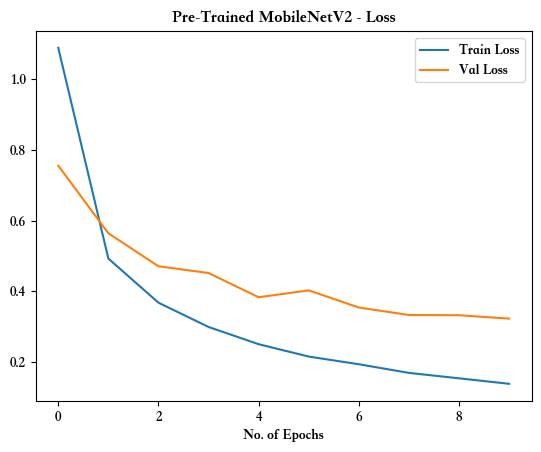

In [13]:
plt.plot(history_trf_model.history['loss'], label='Train Loss')
plt.plot(history_trf_model.history['val_loss'], label='Val Loss')
plt.title('Pre-Trained MobileNetV2 - Loss')
plt.xlabel('No. of Epochs')
plt.legend();

The validation loss measures the difference between the predicted values and the actual values in the validation dataset. A lower validation loss indicates that the model's predictions are closer to the actual values. The validation loss manage to stabalise at the 9th epoch, although a little higher than train loss.

#### 4.5.2 Accuracy over training epochs

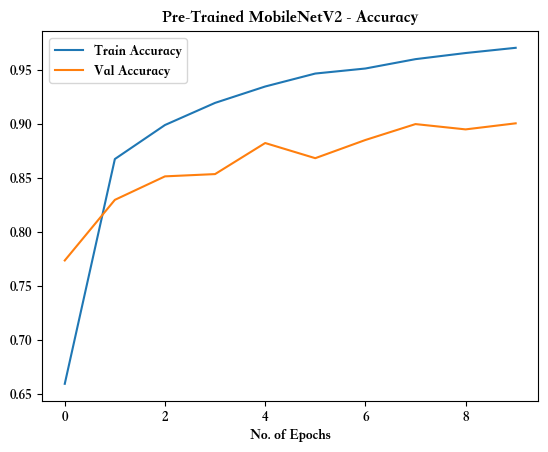

In [14]:
plt.plot(history_trf_model.history['accuracy'], label='Train Accuracy')
plt.plot(history_trf_model.history['val_accuracy'], label='Val Accuracy')
plt.title('Pre-Trained MobileNetV2 - Accuracy')
plt.xlabel('No. of Epochs')
plt.legend();

Despite a very high train accuracy, it is much higher than the validation accuracy. This means that the model is overfitted and may not perform well for unseen data.

#### 4.5.3 AUC over training epochs

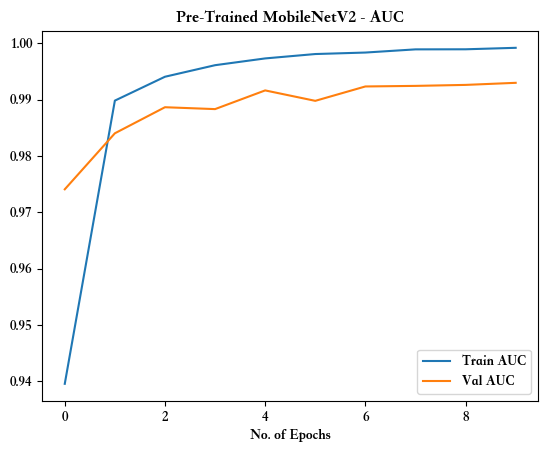

In [15]:
plt.plot(history_trf_model.history['auc'], label='Train AUC')
plt.plot(history_trf_model.history['val_auc'], label='Val AUC')
plt.title('Pre-Trained MobileNetV2 - AUC')
plt.xlabel('No. of Epochs')
plt.legend();

AUC is a measure of the ability of a classifier to distinguish between clsses. The higher the AUC, the better the model's performance, with a perfect AUC score being 1. In this aspect, the model is performing very well.

#### 4.5.4 Summary of Metrics

We will compile these metrics in [05_SVM_Multiclass](05_SVM_Multiclass.ipynb) to do a comparison across all baseline models.

In [16]:
summary_metrics = {}

summary_metrics['Train loss'] = history_trf_model.history['loss'][-1]
summary_metrics['Val loss'] = history_trf_model.history['val_loss'][-1]
summary_metrics['Train accuracy'] = history_trf_model.history['accuracy'][-1]
summary_metrics['Val accuracy'] = history_trf_model.history['val_accuracy'][-1]
summary_metrics['Train AUC'] = history_trf_model.history['auc'][-1]
summary_metrics['Val AUC'] = history_trf_model.history['val_auc'][-1]

print('Summary of metrics for Pre-Trained MobileNetV2')
print(summary_metrics)

Summary of metrics for Pre-Trained MobileNetV2
{'Train loss': 0.13816504180431366, 'Val loss': 0.3228445053100586, 'Train accuracy': 0.9709758162498474, 'Val accuracy': 0.9009831547737122, 'Train AUC': 0.9992102384567261, 'Val AUC': 0.9929900169372559}


#### 4.5.5 Confusion Matrix

A confusion matrix shows the detailed breakdown of the model's predictions and the actual classes.

In [17]:
# Make predictions on the test data
predictions = trf_model.predict(val_data)

# Extract true labels
y_true = val_data.classes

# Extract predicted labels
y_pred = np.argmax(predictions, axis=1)

2024-05-10 03:17:23.333320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 19s 412ms/step


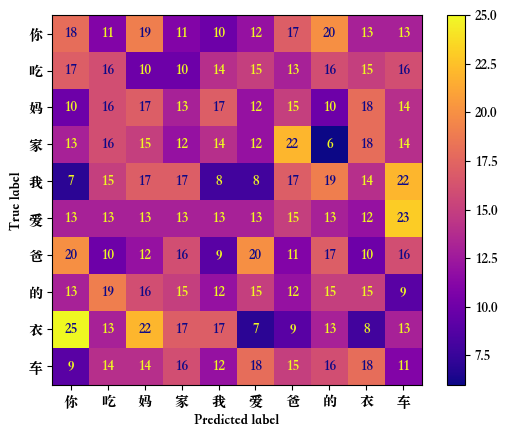

In [18]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
            display_labels=['你', '吃', '妈', '家', '我',
            '爱','爸', '的', '衣', '车'])
disp.plot(cmap='plasma')
plt.show()

Based on the confusion matrix, the number of correct predictions is very low compared to other models. In fact, there are more incorrect predictions than correct ones.

### 4.6 ResNet50V2 - Build Model

The second pre-trained model we will be building is using ResNet50V2. It is known for its depth and high accuracy on image recognition tasks. It belongs to a family of architectures called Residual Networks (ResNets) that address the vanishing gradient problem in very deep neural networks.
  
We will create the model with the following arguments:
  
1. Similar to MobileNetV2, we will disregard its classification head and use our own dense output layer for our multiclass task. We will set `include_top=False`.
  
2. As the final layer of ResNet50V2 is a Global Pooling Layer, not a flattened layer, we will need to set `pooling='avg'` to convert the 2D array into 1D array.
  
3. We will set `pre_trained_model.trainable = False` to freeze the model as we do not want to update the weights of this pre-trained model.

In [19]:
# Import ResNet50V2
pre_trained_model_2 = ResNet50V2(include_top=False, pooling='avg')

# Freeze the model to prevent any updates to the weights
pre_trained_model_2.trainable = False

Next, we will create the model architecture, and add our own dense output layer at the last layer.

In [20]:
# Create our model architecture
trf_model_2 = Sequential() # instantiate empty sequential model using Sequential class

# Add the pre-trained model to get all the weights
trf_model_2.add(pre_trained_model_2) # pre_trained_model = input CNN layers

# Add the final output layer
trf_model_2.add(Dense(10, activation='softmax')) # dense 10-node layer, activation = 'softmax' for multiclass classification

trf_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### 4.7 ResNet50V2 - Compile and Fit Model

To compile the model, we will specify the following:
  
1. We will choose Adam as the `optimizer` to use as it gives good results for most cases, and a learning rate of 0.001 as a start.
  
2. The `loss` function will be categorical crossentropy, since we are doing a multiclass classification.
  
3. The most suitable `metric` for our purpose would be accuracy, as we are concerned if the model can identify the Chinese characters correctly or not. We will also monitor the Area Under the Curve (AUC), which measures the ability of the classifier to distinguish between classes.

In [21]:
# Compile model
opt = Adam(learning_rate=0.001) # optimizer with learning rate of 0.001

# Loss function
trf_model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

Before we fit the model with the training data, we will set the following:
  
1. We will set the number of `epochs` to 10 as the pre-trained model should be able to adapt to our problem pretty fast.
  
2. We will set the `batch_size` to a number that is a power of 2, in this case, 8.

In [22]:
# Set number of epoch and batch size
epoch = 10
batch_size = 8

In [23]:
# Fit model on training data
%time
history_trf_model_2 = trf_model_2.fit(train_data, 
                    batch_size=batch_size,
                    validation_data=val_data,
                    epochs=epoch
                   )

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs
Epoch 1/10


2024-05-10 03:17:44.684201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


188/188 [==============================] - ETA: 0s - loss: 0.9353 - accuracy: 0.7186 - auc: 0.9566

2024-05-10 03:23:26.744289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


188/188 [==============================] - 419s 2s/step - loss: 0.9353 - accuracy: 0.7186 - auc: 0.9566 - val_loss: 0.7159 - val_accuracy: 0.7584 - val_auc: 0.9729
Epoch 2/10
188/188 [==============================] - 396s 2s/step - loss: 0.4120 - accuracy: 0.8894 - auc: 0.9929 - val_loss: 0.5233 - val_accuracy: 0.8413 - val_auc: 0.9852
Epoch 3/10
188/188 [==============================] - 360s 2s/step - loss: 0.2940 - accuracy: 0.9258 - auc: 0.9965 - val_loss: 0.4482 - val_accuracy: 0.8638 - val_auc: 0.9885
Epoch 4/10
188/188 [==============================] - 379s 2s/step - loss: 0.2308 - accuracy: 0.9465 - auc: 0.9980 - val_loss: 0.4083 - val_accuracy: 0.8750 - val_auc: 0.9899
Epoch 5/10
188/188 [==============================] - 385s 2s/step - loss: 0.1902 - accuracy: 0.9553 - auc: 0.9988 - val_loss: 0.3845 - val_accuracy: 0.8785 - val_auc: 0.9902
Epoch 6/10
188/188 [==============================] - 393s 2s/step - loss: 0.1594 - accuracy: 0.9630 - auc: 0.9992 - val_loss: 0.3849 - 

### 4.8 ResNet50V2 - Visualize the Model Training

#### 4.8.1 Loss over training epochs

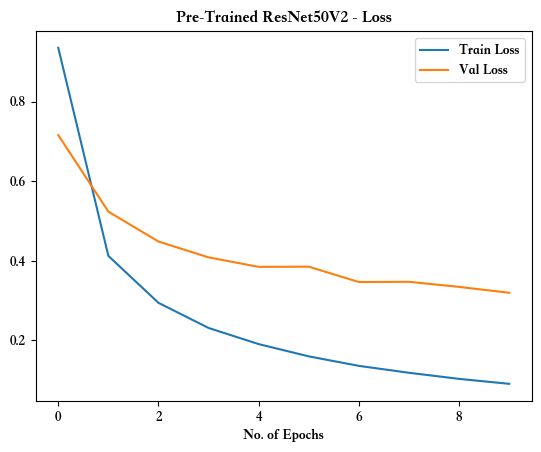

In [24]:
plt.plot(history_trf_model_2.history['loss'], label='Train Loss')
plt.plot(history_trf_model_2.history['val_loss'], label='Val Loss')
plt.title('Pre-Trained ResNet50V2 - Loss')
plt.xlabel('No. of Epochs')
plt.legend();

The validation loss measures the difference between the predicted values and the actual values in the validation dataset. A lower validation loss indicates that the model's predictions are closer to the actual values. Compared to the training loss, the validation loss seems a little higher, although it has been decreasing.

#### 4.8.2 Accuracy over training epochs

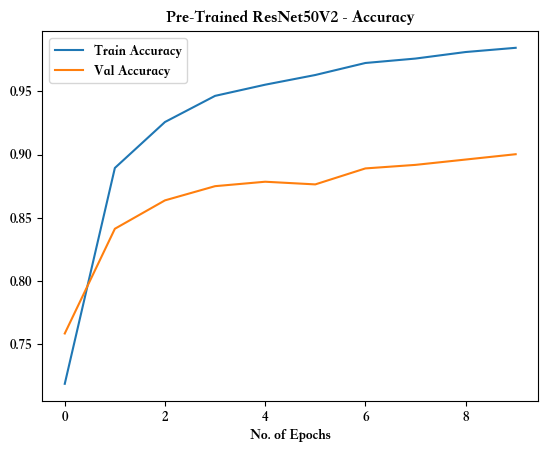

In [25]:
plt.plot(history_trf_model_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_trf_model_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Pre-Trained ResNet50V2 - Accuracy')
plt.xlabel('No. of Epochs')
plt.legend();

Similar to the MobileNetV2 model, the train accuracy is much higher than the validation accuracy. This means that the model is overfitted and may not perform well for unseen data.

#### 4.8.3 AUC over training epochs

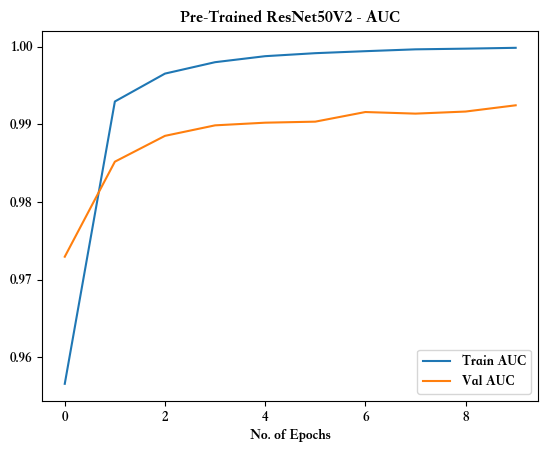

In [26]:
plt.plot(history_trf_model_2.history['auc'], label='Train AUC')
plt.plot(history_trf_model_2.history['val_auc'], label='Val AUC')
plt.title('Pre-Trained ResNet50V2 - AUC')
plt.xlabel('No. of Epochs')
plt.legend();

AUC is a measure of the ability of a classifier to distinguish between clsses. The higher the AUC, the better the model's performance, with a perfect AUC score being 1. In this aspect, the model is performing well.

#### 4.8.4 Summary of Metrics

We will compile these metrics in [05_SVM_Multiclass](05_SVM_Multiclass.ipynb) to do a comparison across all baseline models.

In [27]:
summary_metrics = {}

summary_metrics['Train loss'] = history_trf_model_2.history['loss'][-1]
summary_metrics['Val loss'] = history_trf_model_2.history['val_loss'][-1]
summary_metrics['Train accuracy'] = history_trf_model_2.history['accuracy'][-1]
summary_metrics['Val accuracy'] = history_trf_model_2.history['val_accuracy'][-1]
summary_metrics['Train AUC'] = history_trf_model_2.history['auc'][-1]
summary_metrics['Val AUC'] = history_trf_model_2.history['val_auc'][-1]

print('Summary of metrics for Pre-Trained ResNet50V2')
print(summary_metrics)

Summary of metrics for Pre-Trained ResNet50V2
{'Train loss': 0.09039781987667084, 'Val loss': 0.31935960054397583, 'Train accuracy': 0.9844870567321777, 'Val accuracy': 0.9002808928489685, 'Train AUC': 0.9998509287834167, 'Val AUC': 0.992445170879364}


#### 4.8.5 Confusion Matrix

A confusion matrix shows the detailed breakdown of the model's predictions and the actual classes.

In [28]:
# Make predictions on the test data
predictions_2 = trf_model_2.predict(val_data)

# Extract true labels
y_true = val_data.classes

# Extract predicted labels
y_pred_2 = np.argmax(predictions_2, axis=1)

2024-05-10 04:21:14.337973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 80s 2s/step


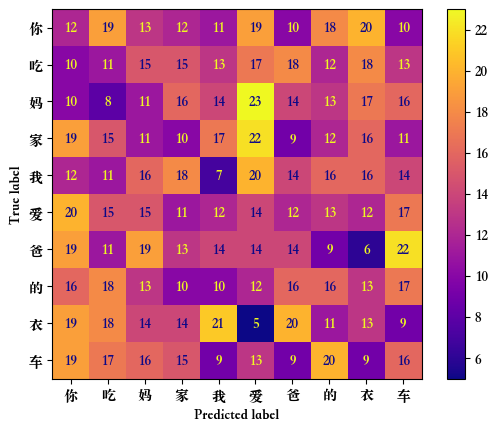

In [29]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
            display_labels=['你', '吃', '妈', '家', '我',
            '爱','爸', '的', '衣', '车'])
disp.plot(cmap='plasma')
plt.show()

Based on the confusion matrix, similar to MobileNetV2, the number of correct predictions is very low compared to other models. In fact, there are more incorrect predictions than correct ones.

### 4.9 Summary

Based on the metrics above, although the accuracy and AUC score for both pre-trained models are quite high, both models suffered from overfitting and thus was unable to generalize for unseen data. This was apparent in the confusion matrix for both models, which yielded very more incorrect than correct prediction. 
  
In the next notebook [05_SVM_Multiclass](05_SVM_Multiclass.ipynb), we will explore another model which does not fall within the realm of deep learning and draw some comparisons.